# Abstract

This notebooks experiments with different models for predicting clicks for the Linear Bidding Strategy. More specifically we used three models: __Logistic Regression__, __Random Forest__ and __XGBoost__. Initially we try some base models to get a baseline of how these models eoughly perform on the validation set, and then we perform __hyperparameter tuning__ using GridSearchCV to retrieve the best ones using as metric the __precision__. The choice of precision intead of some other metric (i.e. recall, AUC etc) was due to the fact that precision actually reflects the CTR performnace. A model with very high precision is a model that can accuratelly predict where the clicks are and produce an accurate pCTR. __An accurate pCTR then enables us to bid truthfully and not over-spend on erroneous predictions__.

# Import and Basic Info

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
import random

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # To ignore SettingWithCopyWarning warning

# Set a random seed for repeatability
rand_seed = 123
random.seed(rand_seed)
np.random.seed(rand_seed)

In [22]:
train = pd.read_csv("train.csv")
validation = pd.read_csv("validation.csv")

In [23]:
train.shape, validation.shape

((2430981, 25), (303925, 25))

# Load dummy and resampled data

In [24]:
from sklearn.externals import joblib

X_resampled = joblib.load("X_train_resampled_pCTR.pkl")
y_resampled = joblib.load("y_train_resampled_pCTR.pkl")
X_validation = joblib.load("X_validation_pCTR.pkl")
y_validation = joblib.load("y_validation_pCTR.pkl")

In [25]:
X_resampled.shape, y_resampled.shape, X_validation.shape, y_validation.shape

((40000, 698), (40000,), (303925, 698), (303925,))

In [26]:
features_total_names = joblib.load("total_features_basebid.pkl")
len(features_total_names)

698

# Modeling

In [27]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, OneClassSVM
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, \
                            precision_score, make_scorer
from sklearn.externals import joblib

In [28]:
def FitAndEvaluateClassifier(estimator, features):
    
    # Data preparation
    X_train = pd.DataFrame(columns = features_total_names, data = X_resampled)[features]
    y_train = y_resampled
    
    X_val = pd.DataFrame(columns = features_total_names, data = X_validation)[features]
    y_val = y_validation
    
    # Fit classifier to training data
    % time estimator.fit(X_train, y_train)
    
    # Predict on validation set
    preds = estimator.predict(X_val)
    
    # Predicted probabilities
    pred_proba = estimator.predict_proba(X_val)
    pred_proba_click = [p[1] for p in pred_proba]
    
    # Evaluate performance
    print("\n")
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, preds))
    print("\n")
    
    # The most important measure is TP/FP rate for the clicked class
    kpi = precision_score(y_val, preds)*100
    print("Click Precision: {}".format(kpi))
    
    # Store probabilities
    submission = pd.DataFrame(data = list(zip(validation["bidid"], pred_proba_click)),
                               columns = ["bidid", "click_proba"])
    
    #submission.to_csv(lr.__doc__.split("(")[0][:-1] + ".csv")
    
    return kpi, submission

## Load features

In [29]:
features_lr = joblib.load("LR-Features.pkl")
features_rf = joblib.load("RF-Features.pkl")

In [30]:
len(features_lr), len(features_rf)

(638, 668)

### Logistic Regression

In [31]:
lr_res, lr_sub = FitAndEvaluateClassifier(LogisticRegression(C = 0.1, random_state = rand_seed), features_lr)

CPU times: user 376 ms, sys: 0 ns, total: 376 ms
Wall time: 378 ms


Confusion Matrix:
[[247523  56200]
 [    61    141]]


Click Precision: 0.2502617986901191


### Random Forest

In [32]:
rf_res, rf_sub = FitAndEvaluateClassifier(RandomForestClassifier(n_estimators = 1000, random_state = rand_seed), \
                                          features_rf)

CPU times: user 2min 56s, sys: 256 ms, total: 2min 57s
Wall time: 2min 57s


Confusion Matrix:
[[301492   2231]
 [   140     62]]


Click Precision: 2.703881378107283


### XGBoost

In [15]:
xgb_res, xgb_sub = FitAndEvaluateClassifier(XGBClassifier(n_estimators = 500, max_depth = 8, learning_rate = 0.1, random_state = rand_seed), 
                                            features_rf)

CPU times: user 9min 13s, sys: 388 ms, total: 9min 14s
Wall time: 9min 14s


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:




Confusion Matrix:
[[301109   2614]
 [   116     86]]


Click Precision: 3.185185185185185


### Visualize pCTR distributions

Text(0.5,1,'XGBoost pCTR districution')

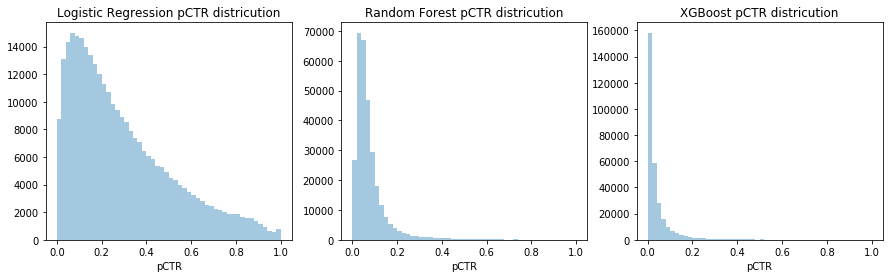

In [35]:
plt.figure(figsize = (15,4))

plt.subplot(1,3,1)
sns.distplot(lr_sub["click_proba"], kde = False)
plt.xlabel("pCTR")
plt.title("Logistic Regression pCTR districution")

plt.subplot(1,3,2)
sns.distplot(rf_sub["click_proba"], kde = False)
plt.xlabel("pCTR")
plt.title("Random Forest pCTR districution")

plt.subplot(1,3,3)
sns.distplot(xgb_sub["click_proba"], kde = False)
plt.xlabel("pCTR")
plt.title("XGBoost pCTR districution")

### Hyperparameter Tuning

In [14]:
lr_grid = {
           "penalty": ["l1", "l2"],
           "C": [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]
          }


rf_grid = {
           "n_estimators": [120, 300, 500, 800, 1000, 1200],
           "max_depth": [5,8,15,25,30]
          }

# xgb_grid = {"n_estimators": [500, 1000],
#             "max_depth": [8,15],
#             "learning_rate": [0.01, 0.1]}

In [15]:
def TuneHyperparameters(estimator, grid, features, name_store):
    
    # Data preparation
    X_train = pd.DataFrame(columns = features_total_names, data = X_resampled)[features]
    y_train = y_resampled
    
    X_val = pd.DataFrame(columns = features_total_names, data = X_validation)[features]
    y_val = y_validation


    # Define grid
    grid = GridSearchCV(estimator, 
                        param_grid = grid, 
                        scoring = "precision", 
                        cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = rand_seed)
                        )

    # Fit grid on train data
    % time grid.fit(X_train, y_train)

    # Store best model
    best_model = grid.best_estimator_
    joblib.dump(best_model, name_store) 
    print("Best parameters: {}".format(grid.best_params_))

    # Predict on validation set
    preds = grid.predict(X_val)
    
    # Predicted probabilities
    pred_proba = grid.predict_proba(X_val)
    pred_proba_click = [p[1] for p in pred_proba]
    
    # Evaluate performance
    print("\n")
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, preds))
    print("\n")
    
    # The most important measure is TP/FP rate for the clicked class
    kpi = precision_score(y_val, preds)*100
    print("Click Precision: {}".format(kpi))
    
    # Store probabilities
    submission = pd.DataFrame(data = list(zip(validation["bidid"], pred_proba_click)),
                               columns = ["bidid", "click_proba"])
    
    return kpi, submission

### Logistic Regression Tuned

In [16]:
lr_res_tuned, lr_sub_tuned = TuneHyperparameters(LogisticRegression(random_state = rand_seed),
                                                 lr_grid,
                                                 features_lr,
                                                 "LR-BestModel.pkl")

CPU times: user 1min 47s, sys: 42.9 s, total: 2min 30s
Wall time: 1min 39s
Best parameters: {'C': 0.001, 'penalty': 'l1'}


Confusion Matrix:
[[281986  21737]
 [    95    107]]


Click Precision: 0.48983702618568026


### Random Forest Tuned

In [ ]:
rf_res_tuned, rf_sub_tuned = TuneHyperparameters(RandomForestClassifier(random_state = rand_seed),
                                                 rf_grid,
                                                features_rf,
                                                 "RF-BestModel.pkl")

CPU times: user 1h 22min 18s, sys: 2.04 s, total: 1h 22min 20s
Wall time: 1h 22min 21s
Best parameters: {'max_depth': 30, 'n_estimators': 300}


Confusion Matrix:
[[298628   5095]
 [   133     69]]


Click Precision: 1.3361735089078235


### XGBoost Tuned

In [1]:
# xgb_res_tuned, xgb_sub_tuned = TuneHyperparameters(XGBClassifier(random_state = rand_seed),
#                                                    xgb_grid,
#                                                    features_rf,
#                                                    "XGBoost-BestModel.pkl")

In [39]:
def StoreXGBModel(features):
    
    # Data preparation
    X_train = pd.DataFrame(columns = features_total_names, data = X_resampled)[features]
    y_train = y_resampled
    
    # Model
    xgb_model = XGBClassifier(n_estimators = 500, max_depth = 8, learning_rate = 0.1, random_state = rand_seed)

    # Fit grid on train data
    % time xgb_model.fit(X_train, y_train)

    # Store model
    joblib.dump(xgb_model, "XGBoost-BestModel.pkl")
    
    return xgb_model

In [40]:
xgb_model_stored = StoreXGBModel(features_rf)

CPU times: user 9min 17s, sys: 360 ms, total: 9min 18s
Wall time: 9min 18s


## Store predictions for validation set

In [ ]:
lr_sub_tuned.to_csv("lr_pCTR.csv")
rf_sub_tuned.to_csv("rf_pCTR.csv")
xgb_sub.to_csv("xgb_pCTR.csv")